In [1]:
import Ouzo_Graph_Tools as ouzo_graphs
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import numpy as np
from scipy import interpolate

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


Loading json containers...
Json container file load complete, listing database
Found 0 containers to add. Starting migration...
Database migration complete!


In [2]:
# Step 1: Load the csv created from the command script.
sample_info = pd.read_csv(r"C:\Users\Edwin\Desktop\12_2_2020\experiment_info") # make it find the blank position from sample_info
pfh_wtfs = [float(i) for i in list(sample_info['Component 1 wtf'])[1:]]
etoh_wtfs = [float(i) for i in list(sample_info['Component 2 wtf'])[1:]]
sample_info

,UID,Component 1 wtf,Component 2 wtf,Component 3 wtf,Component 4 wtf,Component 5 wtf,Slot,Labware,Well
0,UID,dppc wtf,dspe-peg wtf,PFH wtf,ethanol wtf,water wtf,Slot,Labware,Well
1,2020-12-03_dppc_dspe-peg_A1,0.0,6.0769230769230765e-05,0.001,0.6,0.39893923076923077,2,Corning 96 Well Plate 360 µL Flat,A1
2,2020-12-03_dppc_dspe-peg_A2,0.0001282051282051282,6.0769230769230765e-05,0.001,0.6,0.39881102564102566,2,Corning 96 Well Plate 360 µL Flat,A2
3,2020-12-03_dppc_dspe-peg_A3,0.00015384615384615385,6.0769230769230765e-05,0.001,0.6,0.3987853846153846,2,Corning 96 Well Plate 360 µL Flat,A3
4,2020-12-03_dppc_dspe-peg_A4,0.0001794871794871795,6.0769230769230765e-05,0.001,0.6,0.39875974358974364,2,Corning 96 Well Plate 360 µL Flat,A4
...,...,...,...,...,...,...,...,...,...
131,2020-12-03_dppc_dspe-peg_C11,0.0,0.00031461538461538465,0.001,0.6,0.3986853846153846,3,Corning 96 Well Plate 360 µL Flat,C11
132,2020-12-03_dppc_dspe-peg_C12,0.0001282051282051282,0.00031461538461538465,0.001,0.6,0.3985571794871795,3,Corning 96 Well Plate 360 µL Flat,C12
133,2020-12-03_dppc_dspe-peg_D1,0.0,0.00034,0.001,0.6,0.39866,3,Corning 96 Well Plate 360 µL Flat,D1
134,2020-12-03_dppc_dspe-peg_D2,0.0,0.0003653846153846154,0.001,0.6,0.3986346153846154,3,Corning 96 Well Plate 360 µL Flat,D2


In [3]:
# Step 2: Load the UV-Vis data,blank and combine it. 
plate1 =  pd.read_excel(r"C:\Users\Edwin\Desktop\12_2_2020\12_02_20.xlsx", sheet_name = 'Sheet1' ).T
plate2 =  pd.read_excel(r"C:\Users\Edwin\Desktop\12_2_2020\12_02_20.xlsx", sheet_name = 'Sheet2' ).T

In [4]:
# Step 3: Correct all data using baseline/blanking, make series first then subtract using .bbaselinecorrection
blank_series = plate2.iloc[-10]
plate1_blanked = ouzo_graphs.baseline_correction(plate1, blank_series)
plate2_blanked = ouzo_graphs.baseline_correction(plate2, blank_series)
blank_series

0    0.040
1    0.037
2    0.036
3    0.036
4    0.037
5    0.036
Name: D3, dtype: float64

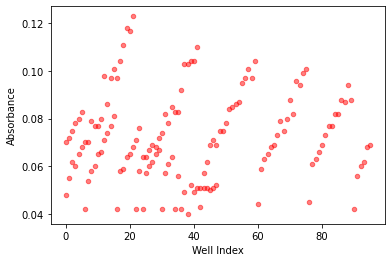

In [5]:
wavelength = 400
plate1_absorbances = ouzo_graphs.plot_single_wavelength(plate1, wavelength)# rearrnge x axis based on concentration or something
plate2_absorbances = ouzo_graphs.plot_single_wavelength(plate2, wavelength)

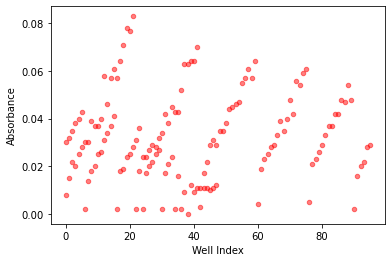

In [6]:
# Step 4: Extract the absorbances from the loaded UV-Vis data at a specified wavelength
wavelength = 400
plate1_absorbances = ouzo_graphs.plot_single_wavelength(plate1_blanked, wavelength)# rearrnge x axis based on concentration or something
plate2_absorbances = ouzo_graphs.plot_single_wavelength(plate2_blanked, wavelength)

In [7]:
# step 5 combine and reorganize
combined_absorbances = plate1_absorbances + plate2_absorbances
print(len(combined_absorbances))
# restrict if analyzed to many cells, but mostly just removing the blank
combined_restricted_xyz = [etoh_wtfs,pfh_wtfs, combined_absorbances[0:-9]]
for i in combined_restricted_xyz:
    print(len(i))

144
135
135
135


In [8]:
# exclude outliers
def exclude_outliers(xyz_list, lower_outlier_z_value, upper_outlier_z_value):
    x_list = xyz_list[0]
    y_list = xyz_list[1]
    z_list = xyz_list[2]
    
    new_x_list = []
    new_y_list = []
    new_z_list = []
    for x,y,z in zip(x_list, y_list, z_list):
        if lower_outlier_z_value<z<upper_outlier_z_value:
            new_x_list.append(x)
            new_y_list.append(y)
            new_z_list.append(z)
    
    return [new_x_list, new_y_list, new_z_list]

In [9]:
# what you should do is use stats to explain and reason outliers in addition to plotting nonoutliter reduced graph
# combined_restricted_xyz = exclude_outliers(combined_restricted_xyz, -0.1, 0.1)
min_x = min(combined_restricted_xyz[0])
max_x = max(combined_restricted_xyz[0])
min_y = min(combined_restricted_xyz[1])
max_y = max(combined_restricted_xyz[1])

<Figure size 576x576 with 0 Axes>

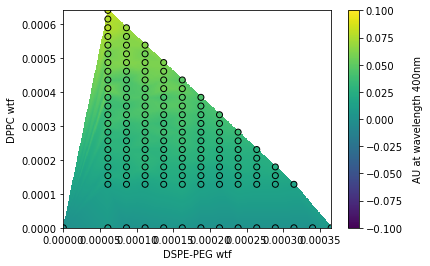

<Figure size 576x576 with 0 Axes>

In [27]:
### First make the xx,yy coordinates that the interpolation will span
x_space = np.linspace(min_x,max_x,500)  # change vmax so it
y_space = np.linspace(min_y,max_y,500)
xx, yy = np.meshgrid(x_space,y_space) 

### Next make tuple the x,y data so it can be fed into interpolation method to make the interpolation mesh

cartcoord = list(zip(combined_restricted_xyz[0],combined_restricted_xyz[1]))
interp = interpolate.LinearNDInterpolator(cartcoord, combined_restricted_xyz[2])
Z0 = interp(xx,yy)

# Finally, create the plot. 
# Note: Mappable for the interpolation is independent of the scatter colormap (which is created automatically), they are the same when you do not restrict either.
# Restriction is defined once you restrict the x/y space of the mesh to a space smaller than that of the scatter plot. 

fig, ax = plt.subplots()
vmin = Z0.min()
vmax = Z0.max()
norm=colors.Normalize(vmin=vmin, vmax=vmax)

mappable = ax.pcolormesh(xx, yy, Z0, norm=norm)
ax.scatter(combined_restricted_xyz[0], combined_restricted_xyz[1], 
           c = combined_restricted_xyz[2], norm=norm, cmap = mpl.cm.viridis, edgecolors='k')

cbar = plt.colorbar(mappable)


cbar_txt = "AU at wavelength " + str(wavelength) + 'nm'
cbar.set_label(cbar_txt, labelpad = 10)
# ax.set_xlim([min_x-min_x/10, max_x+max_x/100]) # simple ratios for easy viewing
# ax.set_ylim([min_y-min_y/10, max_y+max_y/100])
ax.set_xlabel("DSPE-PEG wtf")
ax.set_ylabel("DPPC wtf")
# ax.text(0.4,0.002,'*Negative AU values due to \n instrument resolution of 0.001 AU')
# ax.set_xlim([0.4,0.5])
plt.figure(figsize=(8, 8))

<Figure size 576x432 with 0 Axes>

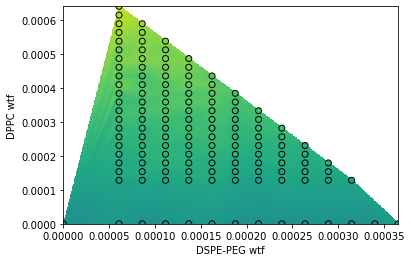

<Figure size 576x432 with 0 Axes>

In [28]:
fig, ax = plt.subplots()
mappable = ax.pcolormesh(xx, yy, Z0, norm=norm)

ax.scatter(combined_restricted_xyz[0], combined_restricted_xyz[1], 
           c = combined_restricted_xyz[2], norm=norm, cmap = mpl.cm.viridis, edgecolors='k')
cbar_txt = "AU at wavelength " + str(wavelength) + 'nm'
cbar.set_label(cbar_txt, labelpad = 10)
# ax.set_xlim([min_x-min_x/10, max_x+max_x/100]) # simple ratios for easy viewing
# ax.set_ylim([min_y-min_y/10, max_y+max_y/100])
ax.set_xlabel("DSPE-PEG wtf")
ax.set_ylabel("DPPC wtf")
# ax.text(0.4,0.002,'*Negative AU values due to \n instrument resolution of 0.001 AU')
# ax.set_xlim([0.4,0.5])
plt.figure(figsize=(8, 6))

In [41]:
for i in Z0:
    print(i)

[ 2.60000000e-02  2.60501002e-02  2.61002004e-02  2.61503006e-02
  2.62004008e-02  2.62505010e-02  2.63006012e-02  2.63507014e-02
  2.64008016e-02  2.64509018e-02  2.65010020e-02  2.65511022e-02
  2.66012024e-02  2.66513026e-02  2.67014028e-02  2.67515030e-02
  2.68016032e-02  2.68517034e-02  2.69018036e-02  2.69519038e-02
  2.70020040e-02  2.70521042e-02  2.71022044e-02  2.71523046e-02
  2.72024048e-02  2.72525050e-02  2.73026052e-02  2.73527054e-02
  2.74028056e-02  2.74529058e-02  2.75030060e-02  2.75531062e-02
  2.76032064e-02  2.76533066e-02  2.77034068e-02  2.77535070e-02
  2.78036072e-02  2.78537074e-02  2.79038076e-02  2.79539078e-02
  2.80040080e-02  2.80541082e-02  2.81042084e-02  2.81543086e-02
  2.82044088e-02  2.82545090e-02  2.83046092e-02  2.83547094e-02
  2.84048096e-02  2.84549098e-02  2.85050100e-02  2.85551102e-02
  2.86052104e-02  2.86553106e-02  2.87054108e-02  2.87555110e-02
  2.88056112e-02  2.88557114e-02  2.89058116e-02  2.89559118e-02
  2.90060120e-02  2.90561

 -0.01       -0.01      ]
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
  3.02154309e-02  3.17935872e-02  3.33717435e-02  3.49498998e-02

 -9.69939880e-03 -9.79959920e-03 -9.89979960e-03 -1.00000000e-02]
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan        

  0.00567134  0.00557114]
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan

 -4.94188377e-03 -4.59118236e-03 -4.24048096e-03 -3.88977956e-03]
[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan        

[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan             nan             nan             nan
             nan         

 -5.12424850e-03 -5.07414830e-03 -5.02404810e-03 -4.97394790e-03]
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         n

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



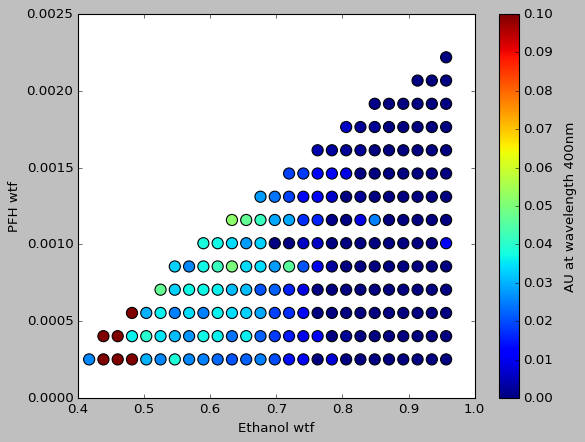

In [71]:
plt.style.use('classic')
plt.scatter(etoh_wtfs, pfh_wtfs, s=100, c = combined_absorbances)
plt.xlabel("Ethanol wtf")
plt.ylabel("PFH wtf")
color_bar = plt.colorbar()
color_bar_txt = "AU at wavelength " + str(wavelength) + 'nm'
color_bar.set_label(color_bar_txt, labelpad = 10)
plt.xlim([0.4,1])
plt.ylim([0, 0.0025])
plt.clim(0, 0.1)
# esentially need to figure out a absorbance which will be a cut off, so we cannot go berlow 0;01
# mappable = ax.pcolormesh(xx, yy, Z0,cmap=cm.inferno)
# how will I automate this

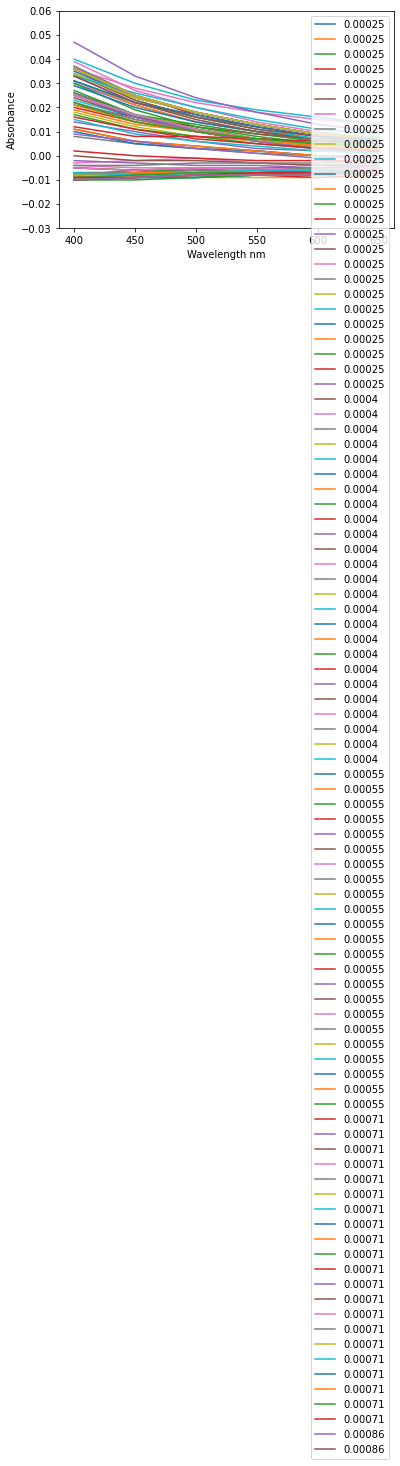

In [114]:
df = plate1_blanked
pfh_wtfs_rounded = [round(wtf,5) for wtf in pfh_wtfs]
ouzo_graphs.plot_wavelengths_zoom(df, pfh_wtfs_rounded, y_lim=[-0.03,0.06]) # so still under resolution
# can you do a color bar like image on this 

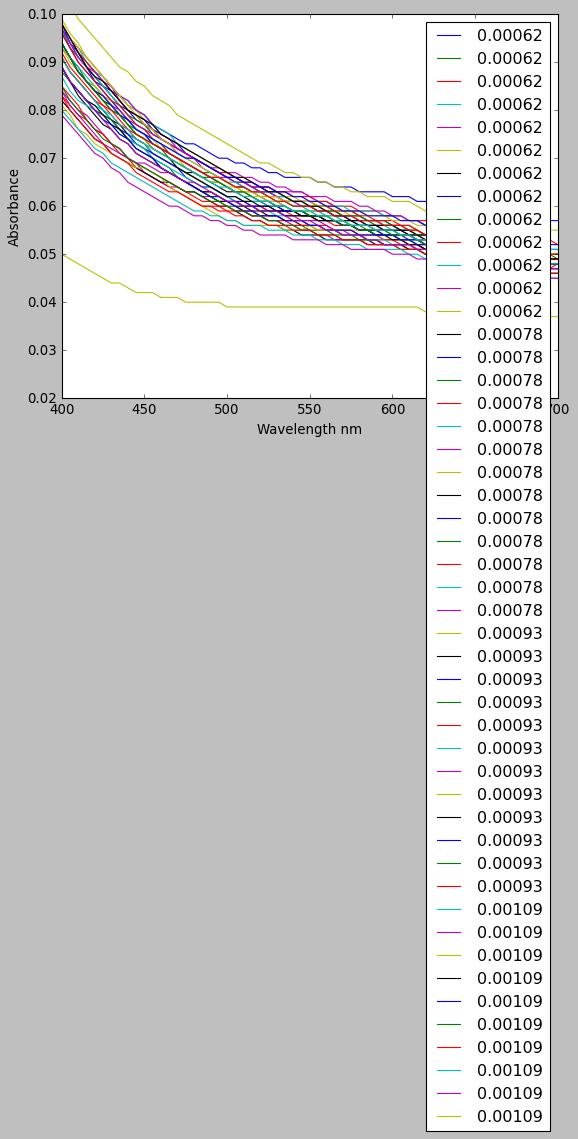

In [37]:
df = plate1
# color_bar = plt.colorbar()
pfh_wtfs_rounded = [round(wtf,5) for wtf in pfh_wtfs]
ouzo_graphs.plot_wavelengths_zoom(df, pfh_wtfs_rounded[0:96], y_lim=[0.02,0.1]) # so still under resolution
# can you do a color bar like image on this 

In [32]:
plate1_blanked

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
Wavelength,400.000,405.000,410.000,415.000,420.000,425.000,430.000,435.000,440.000,445.000,...,655.000,660.000,665.000,670.000,675.000,680.000,685.000,690.000,695.000,700.000
A1,0.048,0.046,0.045,0.044,0.043,0.042,0.041,0.040,0.039,0.038,...,0.021,0.021,0.020,0.020,0.020,0.020,0.019,0.019,0.019,0.019
A2,0.741,0.733,0.727,0.725,0.722,0.725,0.726,0.719,0.715,0.712,...,0.669,0.668,0.670,0.668,0.667,0.667,0.669,0.667,0.666,0.669
A3,0.033,0.032,0.032,0.032,0.031,0.031,0.030,0.028,0.028,0.026,...,0.011,0.011,0.010,0.010,0.010,0.010,0.010,0.009,0.009,0.010
A4,0.048,0.046,0.046,0.044,0.043,0.043,0.042,0.040,0.040,0.038,...,0.013,0.013,0.012,0.012,0.012,0.011,0.011,0.011,0.011,0.011
A5,0.048,0.046,0.046,0.045,0.044,0.043,0.042,0.039,0.038,0.037,...,0.012,0.012,0.012,0.011,0.011,0.011,0.011,0.011,0.011,0.011
A6,0.055,0.053,0.052,0.051,0.050,0.049,0.048,0.046,0.046,0.044,...,0.019,0.019,0.019,0.018,0.018,0.018,0.018,0.018,0.017,0.017
A7,0.041,0.039,0.039,0.038,0.037,0.036,0.035,0.034,0.033,0.032,...,0.011,0.011,0.011,0.010,0.010,0.010,0.010,0.010,0.009,0.009
A8,0.048,0.045,0.045,0.043,0.042,0.041,0.041,0.039,0.038,0.036,...,0.014,0.013,0.013,0.013,0.012,0.012,0.012,0.012,0.012,0.012
B1,0.044,0.042,0.041,0.040,0.040,0.039,0.038,0.036,0.035,0.034,...,0.013,0.013,0.013,0.013,0.012,0.012,0.012,0.012,0.012,0.011
